<a href="https://colab.research.google.com/github/Alilson2/Projeto_IA/blob/main/Projeto_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr # Ler arquivos netcdf
from google.colab import drive
import seaborn as sns


In [ ]:
import os
import xarray as xr

# --- Clonar repositório se não existir ---
if not os.path.exists("Projeto_IA"):
    !git clone https://github.com/Alilson2/Projeto_IA.git
else:
    print("📁 Repositório 'Projeto_IA' já existe — pulando o clone.")

# --- Verificar se a pasta foi criada ---
if not os.path.exists("Projeto_IA"):
    raise FileNotFoundError("❌ A pasta 'Projeto_IA' não foi encontrada. O clone pode ter falhado.")
else:
    print("\n✅ Repositório clonado com sucesso!\n")
    print("Arquivos dentro da pasta Projeto_IA:\n", os.listdir("Projeto_IA"))

# --- Localizar arquivos .nc ---
arquivos_nc = [f for f in os.listdir("Projeto_IA") if f.endswith(".nc")]
if not arquivos_nc:
    raise FileNotFoundError("❌ Nenhum arquivo .nc encontrado na pasta Projeto_IA!")
else:
    print("\n📂 Arquivo(s) NetCDF encontrado(s):")
    for f in arquivos_nc:
        print(" -", f)

# --- Montar lista de caminhos ---
ARQUIVO = [os.path.join("Projeto_IA", f) for f in arquivos_nc]

# --- Função para corrigir longitude ---
def corrigir_longitude(ds):
    for coord in ["longitude", "lon"]:
        if coord in ds.coords:
            ds = ds.assign_coords({coord: ((ds[coord] + 180) % 360) - 180})
            ds = ds.sortby(coord)
    return ds

# --- Abrir arquivos com segurança (nova sintaxe) ---
try:
    dados = xr.open_mfdataset(
        ARQUIVO,
        combine='by_coords',
        parallel=True,           # usa múltiplos núcleos
        preprocess=corrigir_longitude,
        combine_attrs='override' # 🟢 substitui o antigo compat='override'
    )
except ValueError as e:
    print("\n⚠️ Erro na combinação — tentando modo 'nested' (concat por tempo)...")
    dados = xr.open_mfdataset(
        ARQUIVO,
        combine='nested',
        concat_dim='valid_time',  # ajuste se sua dimensão temporal tiver outro nome
        parallel=True,
        preprocess=corrigir_longitude,
        combine_attrs='override'
    )

print("\n✅ Dataset carregado com sucesso!\n")
dados


📁 Repositório 'Projeto_IA' já existe — pulando o clone.

✅ Repositório clonado com sucesso!

Arquivos dentro da pasta Projeto_IA:
 ['(MAI 2020-1 a 24).nc', '(NOVEMBRO 2021-1 a 15).nc', '(FEVEREIRO 2023 - 16a28) 7dc44bd550a6fed4a3ceee541998bb8c.nc', '(JULHO 2023 - 1a15) 6fdadb7142db0ca316d72f4c3cf60eec.nc', '(JUN 2020-25 a 30).nc', 'ABR 2022 - 1a15.nc', 'MAR 2022 - 1a31.nc', 'OUT 2022 - 1a15.nc', '(MAR 2020-26 a 31).nc', '(ABRIL 2023 - 1a15) 7ec70e7a2724bf066c312d9d74c7f942.nc', 'MAI 2022 - 1a15.nc', '(MARÇO 2023 - 16a31) c769088bb86ee3cee8a4fae9a26db382.nc', 'JUN 2022 - 1a15.nc', '(FEV 2020-1 a 24).nc', '(SETEMBRO 2021-16 a 30).nc', 'AGO 2022 - 16a31.nc', '(DEZ 2020-1 a 24).nc', 'SET 2022 - 1a15.nc', '(JUL 2020-1 a 24).nc', '(OUTUBRO 2021-16 a 31).nc', '(DEZEMBRO 2024 - 1a15) eb8accab077c6a6dc49976db8aecbc00.nc', '(MAIO 2023 - 16a31) c5f19b02b4981b080ef04ca83a2585da.nc', '(JUNHO 2023 - 1a15) a6b209ca9f73a07c7a9f05f4683b0ce0.nc', '(AGOSTO 2024 - 1a15) 1df8c66dac3feb3bba4d637487b4677a.nc

/tmp/ipython-input-125324894.py:39: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'longitude' ('longitude',) The recommendation is to set join explicitly for this case.
  dados = xr.open_mfdataset(
/tmp/ipython-input-125324894.py:39: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'latitude' ('latitude',) The recommendation is to set join explicitly for this case.
  dados = xr.open_mfdataset(
/tmp/ipython-input-125324894.py:39: FutureWarning: In a future version of xarray the default value for join will change from

In [ ]:
print(dados['valid_time'])

<xarray.DataArray 'valid_time' (valid_time: 32136)> Size: 257kB
array(['2021-01-01T00:00:00.000000000', '2021-01-01T01:00:00.000000000',
       '2021-01-01T02:00:00.000000000', ..., '2024-12-31T21:00:00.000000000',
       '2024-12-31T22:00:00.000000000', '2024-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 257kB 2021-01-01 ... 2024-12-31T2...
    number      int64 8B 0
    expver      (valid_time) <U4 514kB dask.array<chunksize=(360,), meta=np.ndarray>
Attributes:
    long_name:      time
    standard_name:  time


In [21]:
# --- 2️⃣ Verificar se há a coordenada temporal ---
if "valid_time" not in dados.coords:
    raise ValueError("❌ O dataset não contém uma coordenada temporal chamada 'valid_time'.")

# --- 3️⃣ Converter o eixo temporal para pandas.DatetimeIndex ---
tempo = pd.to_datetime(dados["valid_time"].values)

# --- 4️⃣ Criar DataFrame com componentes temporais ---
df_tempo = pd.DataFrame({
    "timestamp": tempo,
    "timestamp_segundos": tempo.view("int64") / 1e9,   # segundos desde 1970
    "ano": tempo.year,
    "mes": tempo.month,
    "dia": tempo.day,
    "hora": tempo.hour,
    "minuto": tempo.minute,
    "segundo": tempo.second,
    "dia_semana": tempo.dayofweek,
    "dia_do_ano": tempo.dayofyear
})

#print(df_tempo.head())

# Exemplo: seleciona uma variável e um período
# Sort the dataset by valid_time before slicing
dados_sorted = dados.sortby('valid_time')
dados_filtrado = dados_sorted.sel(valid_time=slice("2021-01-01", "2021-02-15"))

# Converte para pandas sem estourar RAM
df_panda = dados_filtrado.to_dataframe().reset_index()

# Junta com df_tempo
df_final = pd.merge(
    df_panda,
    df_tempo,
    left_on='valid_time',
    right_on='timestamp',
    how='left'
)

df_panda

,valid_time,latitude,longitude,d2m,t2m,slhf,sshf,ssrd,e,u10,v10,sp,tp,number,expver
0,2021-01-01 00:00:00,-24.201,-47.197000,296.316650,296.615234,-14757346.0,-649384.0,23078652.0,-0.005901,-0.656839,-1.099172,98480.4375,0.010960,0,0001
1,2021-01-01 00:00:00,-24.201,-47.190000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0001
2,2021-01-01 00:00:00,-24.201,-47.096999,296.031738,297.155273,-13985065.0,-1834398.0,23650256.0,-0.005592,-0.655008,-1.074025,98436.4375,0.012337,0,0001
3,2021-01-01 00:00:00,-24.201,-47.096900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0001
4,2021-01-01 00:00:00,-24.201,-47.090000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12651835,2021-02-15 23:00:00,-23.200,45.703996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0001
12651836,2021-02-15 23:00:00,-23.200,45.803997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0001
12651837,2021-02-15 23:00:00,-23.200,45.903998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0001
12651838,2021-02-15 23:00:00,-23.200,46.003999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0001


In [ ]:
df_panda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11463936 entries, 0 to 11463935
Data columns (total 15 columns):
 #   Column      Dtype         
---  ------      -----         
 0   valid_time  datetime64[ns]
 1   latitude    float64       
 2   longitude   float64       
 3   d2m         float32       
 4   t2m         float32       
 5   slhf        float32       
 6   sshf        float32       
 7   ssrd        float32       
 8   e           float32       
 9   u10         float32       
 10  v10         float32       
 11  sp          float32       
 12  tp          float32       
 13  number      int64         
 14  expver      object        
dtypes: datetime64[ns](1), float32(10), float64(2), int64(1), object(1)
memory usage: 874.6+ MB


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

# Separa features e alvo
X = df_panda.drop(['tp','valid_time'], axis=1)
y = df_panda['tp']

scaler = MinMaxScaler()
scaler.fit(X)
X_train_s = scaler.transform(X)

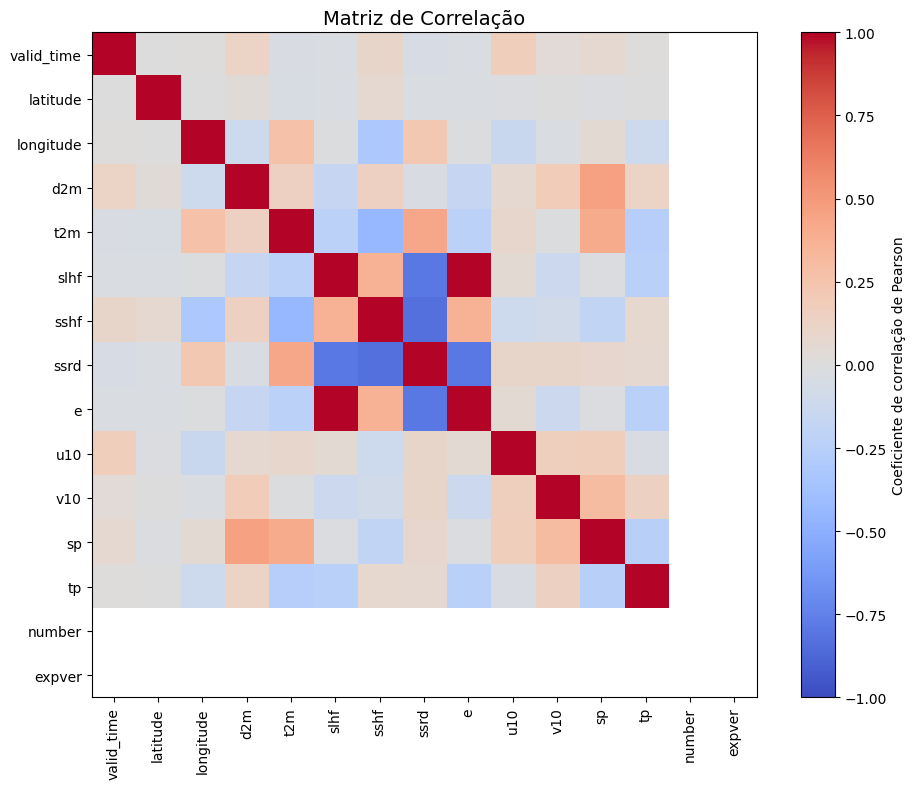

In [ ]:
matrix = df_panda.corr(method='pearson')

plt.figure(figsize=(10, 8))
plt.imshow(matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label="Coeficiente de correlação de Pearson")

plt.title("Matriz de Correlação", fontsize=14)
plt.xticks(range(len(matrix.columns)), matrix.columns, rotation=90)
plt.yticks(range(len(matrix.columns)), matrix.columns)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

# Separa features e alvo
if 'critical_temp' in dados.variables:
    X = dados.drop('critical_temp') #Tirar o prediletor
    y = dados['critical_temp']              #O preditor, separado
else:
    print("Variável 'critical_temp' não encontrada no dataset.")
    # Handle the case where 'critical_temp' is not in the dataset,
    # perhaps by choosing a different target variable or exiting
    # For now, I'll assume you'll need to adjust the code based on your data
    X = dados # Keep all variables as features for now
    y = None # No target variable defined


if y is not None:
    kf = KFold(n_splits=3, random_state=42, shuffle=True)

    # Listas para armazenar os folds (para uso em outras partes)
    X_train_folds, X_test_folds = [], []
    y_train_folds, y_test_folds = [], []

    fold = 1
    for train_index, test_index in kf.split(X):
        print(f"\n=== Fold {fold} ===")

        # Divisão treino/teste
        # Need to convert xarray DataArray to pandas DataFrame for iloc
        X_train = X.isel(valid_time=train_index).to_dataframe()
        X_test = X.isel(valid_time=test_index).to_dataframe()
        y_train = y.isel(valid_time=train_index).to_dataframe()
        y_test = y.isel(valid_time=test_index).to_dataframe()

        print(f"Shape X_train: {X_train.shape}, X_test: {X_test.shape}")

        # Escalonamento e armazena conjuntos
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train_s = scaler.transform(X_train)
        X_test_s = scaler.transform(X_test)

        X_train_folds.append(X_train_s)
        X_test_folds.append(X_test_s)
        y_train_folds.append(y_train)
        y_test_folds.append(y_test)

        fold += 1
else:
    print("Não foi possível prosseguir com a divisão em folds sem uma variável alvo.")

ValueError: the first argument to .drop must be a dictionary

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Listas para armazenar métricas
r2_train_list, r2_test_list = [], []
mse_train_list, mse_test_list = [], []
mae_train_list, mae_test_list = [], []

for i in range(len(X_train_folds)):
    fold = i + 1
    print(f"\n===== Fold {fold} =====")

    # Modelode regressão linear
    a = 0.5
    ridgeReg = Ridge(alpha=a)
    ridgeReg.fit(X_train_folds[i], np.ravel(y_train_folds[i]))  # garante y 1D

    # Predições
    y_pred_train = ridgeReg.predict(X_train_folds[i])
    y_pred_test  = ridgeReg.predict(X_test_folds[i])

    # Métricas
    r2_train = r2_score(y_train_folds[i], y_pred_train)
    r2_test  = r2_score(y_test_folds[i], y_pred_test)
    mse_train = mean_squared_error(y_train_folds[i], y_pred_train)
    mse_test  = mean_squared_error(y_test_folds[i], y_pred_test)
    mae_train = mean_absolute_error(y_train_folds[i], y_pred_train)
    mae_test  = mean_absolute_error(y_test_folds[i], y_pred_test)

    print(f"[Fold {fold}] R² Treino: {r2_train:.4f} | R² Teste: {r2_test:.4f}")
    print(f"[Fold {fold}] MSE Treino: {mse_train:.4f} | MSE Teste: {mse_test:.4f}")
    print(f"[Fold {fold}] MAE Treino: {mae_train:.4f} | MAE Teste: {mae_test:.4f}")

    # Salva o resultado das métricas
    r2_train_list.append(r2_train)
    r2_test_list.append(r2_test)
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)
    mae_train_list.append(mae_train)
    mae_test_list.append(mae_test)

NameError: name 'X_train_folds' is not defined

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Definação das features
features_to_plot = (80, 64)  # Exemplo: primeiras duas features
feature_names_to_plot = [X.columns[features_to_plot[0]], X.columns[features_to_plot[1]]]

# Loop de treino e avaliação por folds
rf_models = []

for i in range(len(X_train_folds)):
    print(f"\n===== Fold {i+1} =====")

    # Treina RandomForestRegressor
    clf = RandomForestRegressor(random_state=42)
    clf.fit(X_train_folds[i], np.ravel(y_train_folds[i]))  # garante y 1D

    # Armazena modelo
    rf_models.append(clf)

    # Avaliação do modelo
    r2_train = clf.score(X_train_folds[i], y_train_folds[i])
    r2_test = clf.score(X_test_folds[i], y_test_folds[i])
    print(f"[Fold {i+1}] R² Treino: {r2_train:.4f} | R² Teste: {r2_test:.4f}")

    # Ranking de importância das features
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = X.columns  # nomes das features

    print(f"\n📊 Ranking de importância das features - Fold {i+1}:\n")
    for rank, idx in enumerate(indices, start=1):
        print(f"{rank:2d}. {feature_names[idx]:<25} — {importances[idx]:.4f}")

    # Gráfico de importância das features
    plt.figure(figsize=(12, 6))
    plt.title(f"Importância das Features - Fold {i+1}")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha="right")
    plt.ylabel("Importância relativa")
    plt.tight_layout()
    plt.show()